In [3]:
import json
import pandas as pd
from pandas import json_normalize

# 1. JSON 로드
with open("test_anilist_top10000.json", "r", encoding="utf-8") as f:
    data = json.load(f)  # data: list[dict]

In [4]:
# 전체를 일단 평탄화
df_raw = json_normalize(data)

# 필요한 컬럼만 골라서 메인 테이블 구성
base_cols = [
    "id",
    "title.english",
    "format",
    "status",
    "season",
    "seasonYear",
    "seasonInt",
    "episodes",
    "duration",
    "averageScore",
    "meanScore",
    "popularity",
    "favourites",
]

df_anime = df_raw[base_cols].copy()

# 컬럼명 좀 깔끔하게 바꾸기
df_anime = df_anime.rename(columns={
    "title.english": "title_english",
})

print(df_anime.head())


       id                   title_english format    status  season  \
0   16498                 Attack on Titan     TV  FINISHED  SPRING   
1  101922  Demon Slayer: Kimetsu no Yaiba     TV  FINISHED  SPRING   
2    1535                      Death Note     TV  FINISHED    FALL   
3  113415                  JUJUTSU KAISEN     TV  FINISHED    FALL   
4   21459                My Hero Academia     TV  FINISHED  SPRING   

   seasonYear  seasonInt  episodes  duration  averageScore  meanScore  \
0      2013.0      132.0      25.0      24.0          85.0       85.0   
1      2019.0      192.0      26.0      24.0          82.0       82.0   
2      2006.0       64.0      37.0      23.0          84.0       84.0   
3      2020.0      204.0      24.0      24.0          84.0       84.0   
4      2016.0      162.0      13.0      24.0          76.0       76.0   

   popularity  favourites  
0      923138       55764  
1      876899       42063  
2      840513       44157  
3      831521       49300  


In [5]:
genre_rows = []

for item in data:
    anime_id = item["id"]
    for g in item.get("genres", []):
        genre_rows.append({"anime_id": anime_id, "genre": g})

df_genres = pd.DataFrame(genre_rows)
print(df_genres.head())


   anime_id    genre
0     16498   Action
1     16498    Drama
2     16498  Fantasy
3     16498  Mystery
4    101922   Action


In [6]:
tag_rows = []

for item in data:
    anime_id = item["id"]
    for tag in item.get("tags", []):
        name = tag.get("name")
        if name:
            tag_rows.append({"anime_id": anime_id, "tag_name": name})

df_tags = pd.DataFrame(tag_rows)
print(df_tags.head())


   anime_id          tag_name
0     16498             Kaiju
1     16498           Revenge
2     16498          Military
3     16498           Tragedy
4     16498  Post-Apocalyptic


In [7]:
studio_rows = []

for item in data:
    anime_id = item["id"]
    studios = item.get("studios") or {}
    nodes = studios.get("nodes") or []
    edges = studios.get("edges") or []

    # nodes와 edges는 같은 길이라고 가정 (AniList 구조)
    for i, node in enumerate(nodes):
        name = node.get("name")
        is_main = None
        if i < len(edges):
            is_main = edges[i].get("isMain")
        if name:
            studio_rows.append({
                "anime_id": anime_id,
                "studio_name": name,
                "is_main": is_main,
            })

df_studios = pd.DataFrame(studio_rows)
print(df_studios.head())


   anime_id     studio_name  is_main
0     16498      WIT STUDIO     True
1     16498     Pony Canyon    False
2     16498        Kodansha    False
3     16498  Production I.G    False
4     16498          Dentsu    False


In [8]:
staff_rows = []

for item in data:
    anime_id = item["id"]
    staff = item.get("staff") or {}
    nodes = staff.get("nodes") or []
    edges = staff.get("edges") or []

    for i, node in enumerate(nodes):
        name_full = None
        name_dict = node.get("name") or {}
        name_full = name_dict.get("full")

        primary_occupations = node.get("primaryOccupations") or []
        # 리스트 → 문자열
        occupations_str = "|".join(primary_occupations) if primary_occupations else None

        role = None
        if i < len(edges):
            role = edges[i].get("role")

        if name_full:
            staff_rows.append({
                "anime_id": anime_id,
                "staff_name": name_full,
                "primary_occupations": occupations_str,
                "role": role,
            })

df_staff = pd.DataFrame(staff_rows)
print(df_staff.head())


   anime_id        staff_name primary_occupations                    role
0     16498     Yuu Kobayashi         Voice Actor         Endcard (ep 12)
1     16498    Mike McFarland         Voice Actor  ADR Director (English)
2     16498       Justin Cook         Voice Actor      Producer (English)
3     16498  J. Michael Tatum         Voice Actor    ADR Script (English)
4     16498      Makoto Raiku             Mangaka         Endcard (ep 10)


In [9]:
df_anime.to_csv("anilist_anime.csv", index=False)
df_genres.to_csv("anilist_anime_genres.csv", index=False)
df_tags.to_csv("anilist_anime_tags.csv", index=False)
df_studios.to_csv("anilist_anime_studios.csv", index=False)
df_staff.to_csv("anilist_anime_staff.csv", index=False)

print("CSV 저장 완료!")


CSV 저장 완료!


In [10]:
import pandas as pd

# 1) CSV 로드
df_anime   = pd.read_csv("anilist_anime.csv")
df_genres  = pd.read_csv("anilist_anime_genres.csv")   # anime_id, genre
df_tags    = pd.read_csv("anilist_anime_tags.csv")     # anime_id, tag_name
df_studios = pd.read_csv("anilist_anime_studios.csv")  # anime_id, studio_name, is_main
df_staff   = pd.read_csv("anilist_anime_staff.csv")    # anime_id, staff_name, primary_occupations, role


In [11]:
# 중복 제거 + 정렬 후 "Action|Comedy" 형태로 합치기
genres_agg = (
    df_genres
    .dropna(subset=["genre"])
    .groupby("anime_id")["genre"]
    .apply(lambda s: "|".join(sorted(set(s))))
    .reset_index()
    .rename(columns={"genre": "genre_list"})
)


In [12]:
tags_agg = (
    df_tags
    .dropna(subset=["tag_name"])
    .groupby("anime_id")["tag_name"]
    .apply(lambda s: "|".join(sorted(set(s))))
    .reset_index()
    .rename(columns={"tag_name": "tag_list"})
)


In [13]:
# is_main이 True인 스튜디오만 골라서 main_studio_name 만들기
main_studio_agg = (
    df_studios[df_studios["is_main"] == True]   # bool 컬럼이면 이렇게 필터
    .dropna(subset=["studio_name"])
    .groupby("anime_id")["studio_name"]
    .first()  # 메인 스튜디오 여러 개여도 첫 번째만
    .reset_index()
    .rename(columns={"studio_name": "main_studio_name"})
)

# 전체 스튜디오 이름을 studio_list로 합치기
all_studio_agg = (
    df_studios
    .dropna(subset=["studio_name"])
    .groupby("anime_id")["studio_name"]
    .apply(lambda s: "|".join(sorted(set(s))))
    .reset_index()
    .rename(columns={"studio_name": "studio_list"})
)


In [14]:
# role에 'Director'가 들어가는 스태프만
mask_director = df_staff["role"].fillna("").str.contains("Director", case=False)
df_director = df_staff[mask_director].copy()

directors_agg = (
    df_director
    .dropna(subset=["staff_name"])
    .groupby("anime_id")["staff_name"]
    .apply(lambda s: "|".join(sorted(set(s))))
    .reset_index()
    .rename(columns={"staff_name": "directors"})
)


In [15]:
# df_anime의 PK는 id, 나머지는 anime_id 기준이므로 left_on/right_on 사용
df_eda = df_anime.copy()

# 장르
df_eda = df_eda.merge(genres_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

# 태그
df_eda = df_eda.merge(tags_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

# 스튜디오 (메인 + 전체)
df_eda = df_eda.merge(main_studio_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

df_eda = df_eda.merge(all_studio_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

# 감독 정보
df_eda = df_eda.merge(directors_agg, left_on="id", right_on="anime_id", how="left")
df_eda.drop(columns=["anime_id"], inplace=True)

print(df_eda.head())
print(df_eda.columns)


       id                   title_english format    status  season  \
0   16498                 Attack on Titan     TV  FINISHED  SPRING   
1  101922  Demon Slayer: Kimetsu no Yaiba     TV  FINISHED  SPRING   
2    1535                      Death Note     TV  FINISHED    FALL   
3  113415                  JUJUTSU KAISEN     TV  FINISHED    FALL   
4   21459                My Hero Academia     TV  FINISHED  SPRING   

   seasonYear  seasonInt  episodes  duration  averageScore  meanScore  \
0      2013.0      132.0      25.0      24.0          85.0       85.0   
1      2019.0      192.0      26.0      24.0          82.0       82.0   
2      2006.0       64.0      37.0      23.0          84.0       84.0   
3      2020.0      204.0      24.0      24.0          84.0       84.0   
4      2016.0      162.0      13.0      24.0          76.0       76.0   

   popularity  favourites                                   genre_list  \
0      923138       55764                 Action|Drama|Fantasy|Mys

In [16]:
def build_anilist_eda_dataframe(base_path: str = ".") -> pd.DataFrame:
    # 1) CSV 로드
    df_anime   = pd.read_csv(f"{base_path}/anilist_anime.csv")
    df_genres  = pd.read_csv(f"{base_path}/anilist_anime_genres.csv")
    df_tags    = pd.read_csv(f"{base_path}/anilist_anime_tags.csv")
    df_studios = pd.read_csv(f"{base_path}/anilist_anime_studios.csv")
    df_staff   = pd.read_csv(f"{base_path}/anilist_anime_staff.csv")

    # 2) 장르 집계
    genres_agg = (
        df_genres.dropna(subset=["genre"])
        .groupby("anime_id")["genre"]
        .apply(lambda s: "|".join(sorted(set(s))))
        .reset_index()
        .rename(columns={"genre": "genre_list"})
    )

    # 3) 태그 집계
    tags_agg = (
        df_tags.dropna(subset=["tag_name"])
        .groupby("anime_id")["tag_name"]
        .apply(lambda s: "|".join(sorted(set(s))))
        .reset_index()
        .rename(columns={"tag_name": "tag_list"})
    )

    # 4) 스튜디오 집계
    main_studio_agg = (
        df_studios[df_studios["is_main"] == True]
        .dropna(subset=["studio_name"])
        .groupby("anime_id")["studio_name"]
        .first()
        .reset_index()
        .rename(columns={"studio_name": "main_studio_name"})
    )

    all_studio_agg = (
        df_studios
        .dropna(subset=["studio_name"])
        .groupby("anime_id")["studio_name"]
        .apply(lambda s: "|".join(sorted(set(s))))
        .reset_index()
        .rename(columns={"studio_name": "studio_list"})
    )

    # 5) 감독 집계
    mask_director = df_staff["role"].fillna("").str.contains("Director", case=False)
    df_director = df_staff[mask_director].copy()

    directors_agg = (
        df_director
        .dropna(subset=["staff_name"])
        .groupby("anime_id")["staff_name"]
        .apply(lambda s: "|".join(sorted(set(s))))
        .reset_index()
        .rename(columns={"staff_name": "directors"})
    )

    # 6) 병합
    df_eda = df_anime.copy()

    for agg_df in [genres_agg, tags_agg, main_studio_agg, all_studio_agg, directors_agg]:
        df_eda = df_eda.merge(agg_df, left_on="id", right_on="anime_id", how="left")
        df_eda.drop(columns=["anime_id"], inplace=True)

    return df_eda


# 사용 예시
df_eda = build_anilist_eda_dataframe(base_path=".")
print(df_eda.head())


       id                   title_english format    status  season  \
0   16498                 Attack on Titan     TV  FINISHED  SPRING   
1  101922  Demon Slayer: Kimetsu no Yaiba     TV  FINISHED  SPRING   
2    1535                      Death Note     TV  FINISHED    FALL   
3  113415                  JUJUTSU KAISEN     TV  FINISHED    FALL   
4   21459                My Hero Academia     TV  FINISHED  SPRING   

   seasonYear  seasonInt  episodes  duration  averageScore  meanScore  \
0      2013.0      132.0      25.0      24.0          85.0       85.0   
1      2019.0      192.0      26.0      24.0          82.0       82.0   
2      2006.0       64.0      37.0      23.0          84.0       84.0   
3      2020.0      204.0      24.0      24.0          84.0       84.0   
4      2016.0      162.0      13.0      24.0          76.0       76.0   

   popularity  favourites                                   genre_list  \
0      923138       55764                 Action|Drama|Fantasy|Mys

In [17]:
df_eda.head()

,id,title_english,format,status,season,seasonYear,seasonInt,episodes,duration,averageScore,meanScore,popularity,favourites,genre_list,tag_list,main_studio_name,studio_list,directors
0,16498,Attack on Titan,TV,FINISHED,SPRING,2013.0,132.0,25.0,24.0,85.0,85.0,923138,55764,Action|Drama|Fantasy|Mystery,Adoption|Amnesia|CGI|Cannibalism|Coming of Age...,WIT STUDIO,Dentsu|Kodansha|Mainichi Broadcasting System|P...,Mike McFarland|Sayo Yamamoto|Tetsurou Araki
1,101922,Demon Slayer: Kimetsu no Yaiba,TV,FINISHED,SPRING,2019.0,192.0,26.0,24.0,82.0,82.0,876899,42063,Action|Adventure|Drama|Fantasy|Supernatural,Animals|Body Horror|CGI|Chibi|Curses|Demons|Fo...,ufotable,Aniplex|Aniplex of America|Shueisha|ufotable,Cassius Romero|Haruo Sotozaki|Steve Staley
2,1535,Death Note,TV,FINISHED,FALL,2006.0,64.0,37.0,23.0,84.0,84.0,840513,44157,Mystery|Psychological|Supernatural|Thriller,Achronological Order|Acting|Amnesia|Anti-Hero|...,MADHOUSE,Ashi Productions|Konami|MADHOUSE|Nippon Televi...,Takahiro Kagami|Takehiro Hamatsu|Tetsurou Arak...
3,113415,JUJUTSU KAISEN,TV,FINISHED,FALL,2020.0,204.0,24.0,24.0,84.0,84.0,831521,49300,Action|Drama|Supernatural,Anthropomorphism|Baseball|Boarding School|Body...,MAPPA,MAPPA|Mainichi Broadcasting System|Shueisha|Su...,Hironori Tanaka|Michael Sorich|Patricia Aceved...
4,21459,My Hero Academia,TV,FINISHED,SPRING,2016.0,162.0,13.0,24.0,76.0,76.0,777648,20698,Action|Adventure|Comedy,Bullying|Coming of Age|Cultivation|Ensemble Ca...,bones,Dentsu|Mainichi Broadcasting System|Movic|Toho...,Colleen Clinkenbeard|Toshihiro Kawamoto|Yoshih...


In [18]:
print(df_eda.shape)
print(df_eda.dtypes)
print(df_eda.info())

(10000, 18)
id                    int64
title_english        object
format               object
status               object
season               object
seasonYear          float64
seasonInt           float64
episodes            float64
duration            float64
averageScore        float64
meanScore           float64
popularity            int64
favourites            int64
genre_list           object
tag_list             object
main_studio_name     object
studio_list          object
directors            object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   title_english     6836 non-null   object 
 2   format            10000 non-null  object 
 3   status            10000 non-null  object 
 4   season            9127 non-null   object 
 5   seasonYear        9127 non-n

In [19]:
print(df_eda.describe())
print(df_eda['title_english'].value_counts())
print(df_eda['studio_list'].value_counts())
print(df_eda['format'].value_counts())

                  id   seasonYear    seasonInt    episodes     duration  \
count   10000.000000  9127.000000  9146.000000  9719.00000  9670.000000   
mean    57473.556100  2010.052591   274.777170    13.42134    30.683764   
std     63920.828649    11.834515   291.676414    31.83612    27.405221   
min         1.000000  1943.000000     0.000000     1.00000     1.000000   
25%      3483.500000  2004.000000   111.000000     1.00000    20.000000   
50%     20517.500000  2013.000000   172.000000    10.00000    24.000000   
75%    110786.500000  2019.000000   234.000000    13.00000    27.000000   
max    202564.000000  2027.000000   994.000000  1787.00000   168.000000   

       averageScore    meanScore     popularity   favourites  
count   9676.000000  9701.000000   10000.000000  10000.00000  
mean      64.898098    66.054530   26284.124100    637.05010  
std        9.548405     9.480627   62305.817537   2748.09834  
min       16.000000    10.000000     741.000000      0.00000  
25%      

In [20]:
df_eda.isna().sum()
df_eda.isnull().sum()

id                     0
title_english       3164
format                 0
status                 0
season               873
seasonYear           873
seasonInt            854
episodes             281
duration             330
averageScore         324
meanScore            299
popularity             0
favourites             0
genre_list            93
tag_list             203
main_studio_name    1785
studio_list          449
directors           1548
dtype: int64

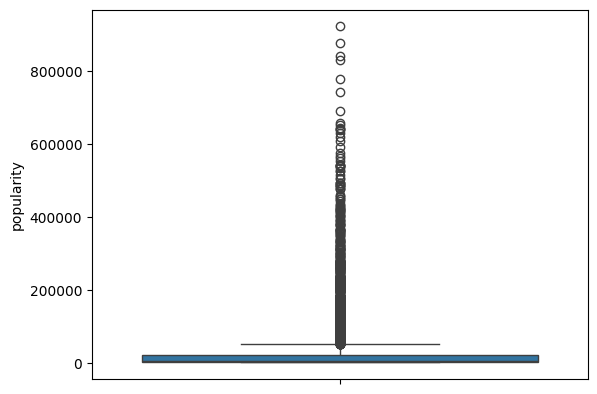

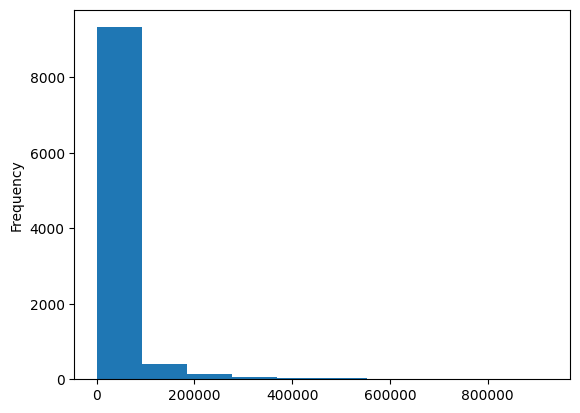

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.boxplot(df_eda, y='popularity', whis=1.5)
plt.show()

df_eda['popularity'].plot(kind='hist')
plt.show()

In [22]:
print(df_eda.duplicated().sum())

0


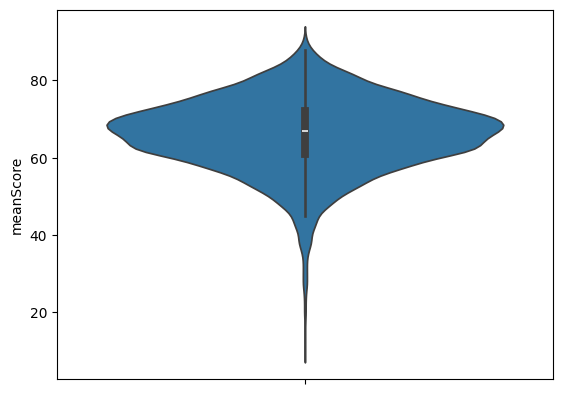

In [23]:
sns.violinplot(df_eda, y='meanScore')
plt.show()

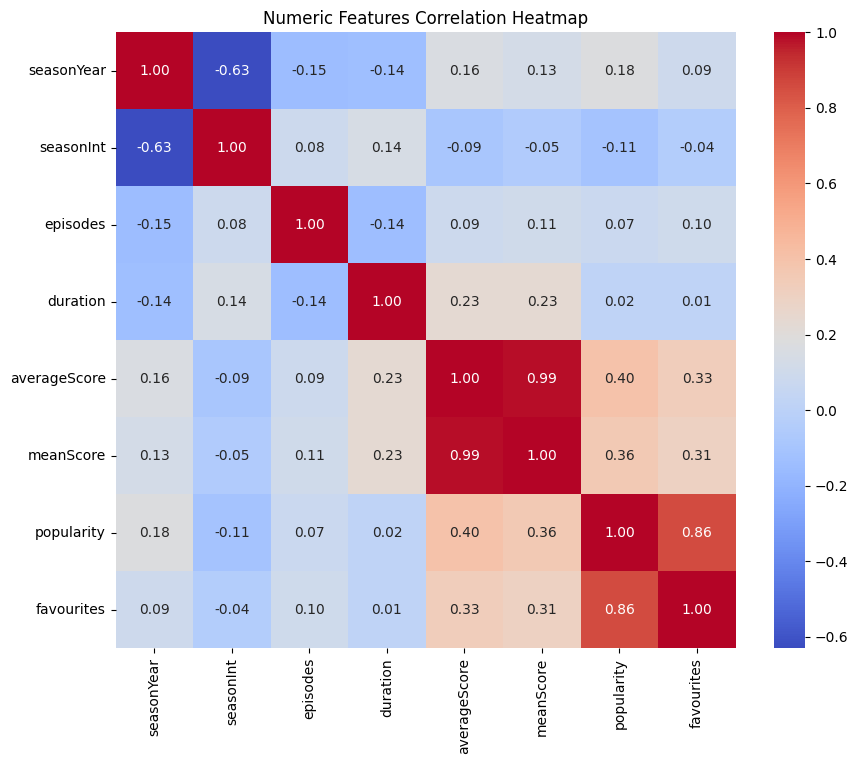

In [27]:
numeric_cols = [
    "seasonYear", "seasonInt", "episodes", "duration",
    "averageScore", "meanScore", "popularity", "favourites"
]

corr = df_eda[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric Features Correlation Heatmap")
plt.show()

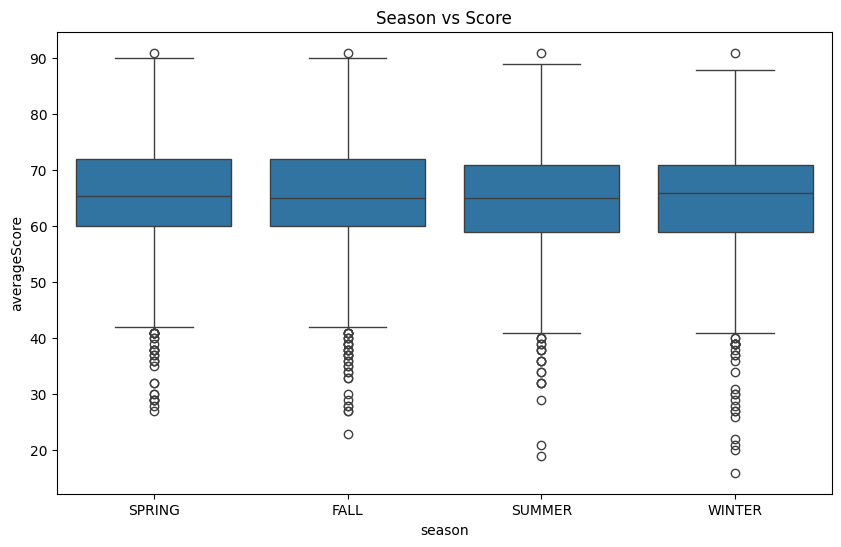

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_eda, x="season", y="averageScore")
plt.title("Season vs Score")
plt.show()

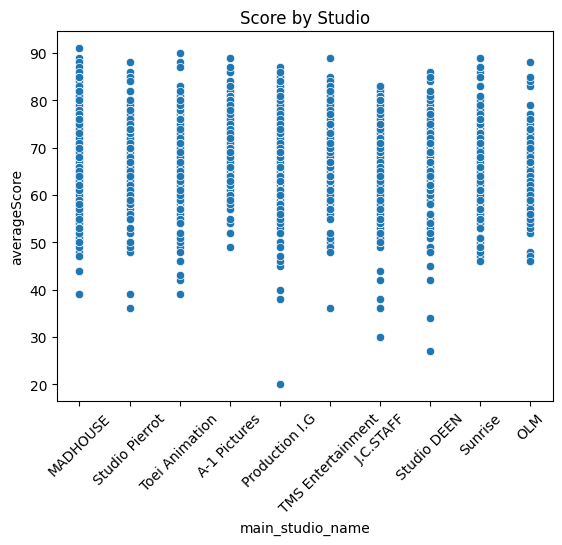

In [34]:
top_studios = df_eda['main_studio_name'].value_counts().head(10).index
sns.scatterplot(data=df_eda[df_eda["main_studio_name"].isin(top_studios)],
            x="main_studio_name", y="averageScore")
plt.xticks(rotation=45)
plt.title("Score by Studio")
plt.show()